## Actividad: Ensambles en un problema real (trabajo individual o en parejas)

**Datos**: Elige un dataset binario de Kaggle (churn/fraude/crédito o similar).  
**Flujo mínimo exigido (sin validación cruzada):**
1) Particiona en *train/test* con `train_test_split` (estratificado).  
2) Entrena tres clasificadores base (sugerencia: Regresión Logística, Árbol, SVM con `probability=True`).  
3) Compara `VotingClassifier` con `voting='hard'` y `voting='soft'`.  
4) Entrena `BaggingClassifier` (árbol base).  
5) Entrena `RandomForestClassifier` con `oob_score=True`; reporta OOB y compáralo con test.  
6) Reporta **Accuracy, Precision, Recall, F1** y matriz de confusión.  
7) Muestra **feature importances** (MDI) y, si el dataset tiene >5 features, complementa con **Permutation Importance**.  
8) **Discusión** (10–15 líneas): ¿qué método funcionó mejor y por qué? Relaciona con diversidad, varianza, *oob*, y la posible calibración de probabilidades (hard vs soft voting).


## Rúbrica

| **Dimensión**                                                                  | **5 — Excelente**                                                                                                                | **4 — Muy bueno**                                                                          | **3 — Aceptable**                                                            | **2 — Básico**                                                      | **1 — Insuficiente**                                               |
| ------------------------------------------------------------------------------ | -------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------ | ---------------------------------------------------------------------------- | ------------------------------------------------------------------- | ------------------------------------------------------------------ |
| **Preparación y partición de datos**                                           | Realiza la partición estratificada de manera correcta; justifica la elección y asegura balance entre clases.                     | Realiza partición estratificada correcta, pero con justificación superficial.              | Partición realizada, pero no asegura balance en todas las clases.            | Partición realizada parcialmente, con errores en estratificación.   | No realiza partición correcta o no entrega evidencia del proceso.  |
| **Implementación de clasificadores base**                                      | Entrena correctamente 3 clasificadores distintos, configurados con parámetros adecuados, justifica su elección.                  | Entrena 3 clasificadores, con pequeños errores de configuración o sin justificación clara. | Entrena solo 2 clasificadores correctamente.                                 | Entrena 1 clasificador o los entrena con errores graves.            | No implementa clasificadores o el código no funciona.              |
| **Uso de métodos de ensamble (Voting, Bagging, Random Forest)**                | Implementa y compara Voting (hard y soft), Bagging y Random Forest con OOB correctamente; explica resultados.                    | Implementa los 3 métodos, con leves errores o explicaciones incompletas.                   | Implementa 2 métodos de ensamble correctamente.                              | Implementa solo 1 método o los aplica con errores graves.           | No implementa métodos de ensamble o los resultados no son válidos. |
| **Métricas de evaluación (Accuracy, Precision, Recall, F1, Confusion Matrix)** | Reporta todas las métricas con claridad; interpreta correctamente cada una con respecto al problema.                             | Reporta todas las métricas, pero con interpretación superficial.                           | Reporta solo parte de las métricas o con errores menores.                    | Reporta pocas métricas y con errores en su interpretación.          | No reporta métricas o son incorrectas.                             |
| **Feature Importances (MDI y Permutation)**                                    | Presenta importancias correctamente calculadas y explicadas; compara MDI vs Permutation con interpretación crítica.              | Presenta importancias con explicación parcial o comparación superficial.                   | Calcula solo un tipo de importancia (MDI o Permutation) sin discusión clara. | Calcula importancias con errores o sin relación con el problema.    | No reporta ni analiza importancias.                                |
| **Discusión y análisis crítico**                                               | Discusión profunda (10–15 líneas), conecta con diversidad, varianza, OOB y calibración; argumenta qué método es mejor y por qué. | Discusión adecuada (8–12 líneas), toca la mayoría de los puntos pedidos.                   | Discusión básica (5–8 líneas), cubre parcialmente los puntos.                | Discusión mínima (menos de 5 líneas) o sin profundidad analítica.   | No presenta discusión o carece de relación con la actividad.       |
| **Claridad, orden y presentación**                                             | Trabajo impecable, con código organizado, comentarios claros y redacción fluida.                                                 | Trabajo bien organizado, con leves errores de orden o redacción.                           | Trabajo aceptable, pero con secciones poco claras o desordenadas.            | Trabajo poco organizado y con deficiencias importantes en claridad. | Trabajo desordenado, sin coherencia ni presentación adecuada.      |


In [152]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [153]:
df = pd.read_csv("./loan_data.csv")
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [155]:
categorical = list(df.select_dtypes(include=['object']).columns)


In [156]:
for c in categorical:
    display(df[c].value_counts())
    print("\n")

person_gender
male      24841
female    20159
Name: count, dtype: int64

person_education
Bachelor       13399
Associate      12028
High School    11972
Master          6980
Doctorate        621
Name: count, dtype: int64

person_home_ownership
RENT        23443
MORTGAGE    18489
OWN          2951
OTHER         117
Name: count, dtype: int64

loan_intent
EDUCATION            9153
MEDICAL              8548
VENTURE              7819
PERSONAL             7552
DEBTCONSOLIDATION    7145
HOMEIMPROVEMENT      4783
Name: count, dtype: int64

previous_loan_defaults_on_file
Yes    22858
No     22142
Name: count, dtype: int64

In [157]:
df['previous_loan_defaults_on_file']= df['previous_loan_defaults_on_file'].apply(lambda x: True if x=='Yes' else False,)

In [158]:
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,False,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,True,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,False,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,False,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,False,1


In [159]:
df.dropna(inplace=True)
df['loan_status'] = df['loan_status'].apply(lambda x: True if x==1 else False)

In [160]:


numeric_cols = df.select_dtypes(include='number').columns
non_numeric_cols = df.select_dtypes(exclude='number').columns
sc = StandardScaler()
scaled_array = sc.fit_transform(df[numeric_cols])

scaled_df = pd.DataFrame(scaled_array, columns=numeric_cols, index=df.index)

df = pd.concat([scaled_df, df[non_numeric_cols]], axis=1)
df

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,person_gender,person_education,person_home_ownership,loan_intent,previous_loan_defaults_on_file,loan_status
0,-0.953538,-0.104090,-0.892284,4.024953,1.683039,4.016394,-0.739109,-1.419814,female,Master,RENT,PERSONAL,False,True
1,-1.118963,-0.846005,-0.892284,-1.359209,0.044782,-0.684829,-0.996863,-2.549975,female,High School,OWN,EDUCATION,True,False
2,-0.457264,-0.844065,-0.397517,-0.646600,0.625557,3.443074,-0.739109,0.047412,female,High School,MORTGAGE,MEDICAL,False,True
3,-0.788113,-0.007039,-0.892284,4.024953,1.417829,3.443074,-0.996863,0.840507,female,Bachelor,RENT,MEDICAL,False,True
4,-0.622689,-0.176371,-0.727362,4.024953,1.095549,4.475050,-0.481354,-0.924130,male,Master,RENT,MEDICAL,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,-0.126414,-0.402231,0.097249,0.857799,1.562184,1.952442,-0.739109,0.245686,male,Associate,RENT,MEDICAL,False,True
44996,1.527834,-0.180537,1.911393,-0.092348,1.028407,0.003155,1.322928,-0.230171,female,Associate,RENT,HOMEIMPROVEMENT,False,True
44997,0.866135,-0.290681,0.262171,-1.078758,-0.331212,-1.028821,1.065174,0.701716,male,Associate,RENT,DEBTCONSOLIDATION,False,True
44998,0.204436,-0.586348,-0.232595,0.382726,0.746412,2.525762,0.034155,-0.567237,male,Bachelor,RENT,EDUCATION,False,True


In [161]:
df_encoded = pd.get_dummies(df, columns=categorical, drop_first=True)
df_no_categorical = df.drop(columns=categorical)
df_to_train = pd.concat([df_encoded, df_no_categorical],axis=1)
df_to_train

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status,person_gender_male,...,previous_loan_defaults_on_file_True,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
0,-0.953538,-0.104090,-0.892284,4.024953,1.683039,4.016394,-0.739109,-1.419814,True,False,...,False,-0.953538,-0.104090,-0.892284,4.024953,1.683039,4.016394,-0.739109,-1.419814,True
1,-1.118963,-0.846005,-0.892284,-1.359209,0.044782,-0.684829,-0.996863,-2.549975,False,False,...,True,-1.118963,-0.846005,-0.892284,-1.359209,0.044782,-0.684829,-0.996863,-2.549975,False
2,-0.457264,-0.844065,-0.397517,-0.646600,0.625557,3.443074,-0.739109,0.047412,True,False,...,False,-0.457264,-0.844065,-0.397517,-0.646600,0.625557,3.443074,-0.739109,0.047412,True
3,-0.788113,-0.007039,-0.892284,4.024953,1.417829,3.443074,-0.996863,0.840507,True,False,...,False,-0.788113,-0.007039,-0.892284,4.024953,1.417829,3.443074,-0.996863,0.840507,True
4,-0.622689,-0.176371,-0.727362,4.024953,1.095549,4.475050,-0.481354,-0.924130,True,True,...,False,-0.622689,-0.176371,-0.727362,4.024953,1.095549,4.475050,-0.481354,-0.924130,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,-0.126414,-0.402231,0.097249,0.857799,1.562184,1.952442,-0.739109,0.245686,True,True,...,False,-0.126414,-0.402231,0.097249,0.857799,1.562184,1.952442,-0.739109,0.245686,True
44996,1.527834,-0.180537,1.911393,-0.092348,1.028407,0.003155,1.322928,-0.230171,True,False,...,False,1.527834,-0.180537,1.911393,-0.092348,1.028407,0.003155,1.322928,-0.230171,True
44997,0.866135,-0.290681,0.262171,-1.078758,-0.331212,-1.028821,1.065174,0.701716,True,True,...,False,0.866135,-0.290681,0.262171,-1.078758,-0.331212,-1.028821,1.065174,0.701716,True
44998,0.204436,-0.586348,-0.232595,0.382726,0.746412,2.525762,0.034155,-0.567237,True,True,...,False,0.204436,-0.586348,-0.232595,0.382726,0.746412,2.525762,0.034155,-0.567237,True


In [162]:


y = df_to_train['loan_status']
y = np.squeeze(y.loc[:, ~y.columns.duplicated()])
X = df_to_train.drop('loan_status', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [163]:


metricas = []
matrices = []
log_clf = LogisticRegression(random_state=42)
tree_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
svc_clf = SVC(kernel="rbf", gamma="scale", probability=True, random_state=42)  # probability=True habilita soft voting


voting_hard = VotingClassifier(
    estimators=[("lr", log_clf), ("tree", tree_clf), ("svc", svc_clf)],
    voting="hard"
)

voting_soft = VotingClassifier(
    estimators=[("lr", log_clf), ("tree", tree_clf), ("svc", svc_clf)],
    voting="soft" 
)
bagging = BaggingClassifier(
    estimator=tree_clf,
    n_estimators=10,
    random_state=42
)
for name, clf in [("LogReg", log_clf), ("Tree", tree_clf), ("Bagging", bagging), ("SVC", svc_clf), ("HardVote", voting_hard), ("SoftVote", voting_soft)]:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    resultados = {'Modelo': name,'Accuracy':acc,'F1_score':f1,'Recall':rec,'Precision':precision}
    metricas.append(resultados)
    print(f"{name:9s}  Acc={acc:.3f}  F1={f1:.3f} Recall = {rec} Precision = {precision}")
    matriz = confusion_matrix(y_test, y_pred)
    matrices.append({'nombre':name,'modelo': clf,'matriz':matriz})
    


LogReg     Acc=0.900  F1=0.768 Recall = 0.7456 Precision = 0.7915074309978769
Tree       Acc=0.911  F1=0.781 Recall = 0.7196 Precision = 0.8550380228136882
Bagging    Acc=0.911  F1=0.781 Recall = 0.7132 Precision = 0.8634382566585956
SVC        Acc=0.917  F1=0.802 Recall = 0.7536 Precision = 0.8563636363636363
HardVote   Acc=0.918  F1=0.803 Recall = 0.7556 Precision = 0.8563009972801451
SoftVote   Acc=0.920  F1=0.809 Recall = 0.7608 Precision = 0.8633681343622334


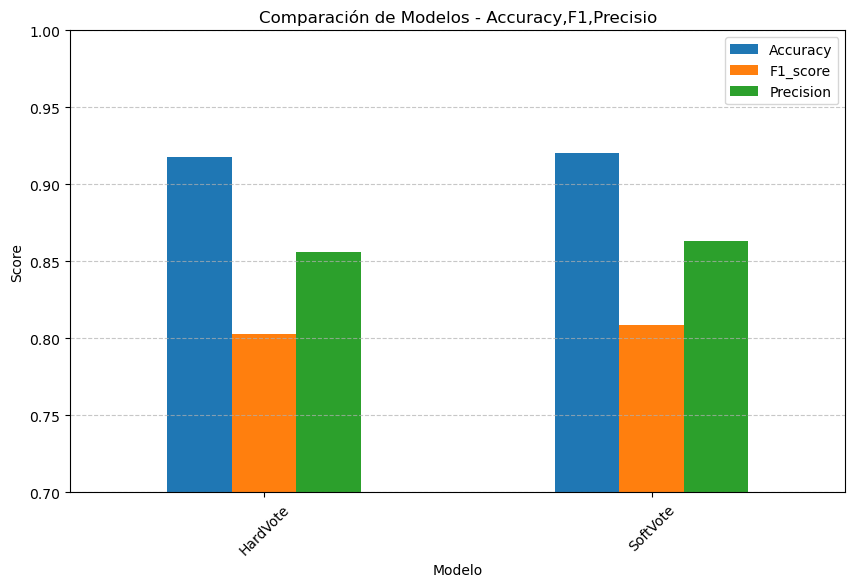

In [164]:
df_metricas = pd.DataFrame(metricas)

ax = df_metricas[df_metricas['Modelo'].isin(['HardVote', 'SoftVote'])].plot(x="Modelo", y=["Accuracy", "F1_score","Precision"], kind="bar", figsize=(10,6))
plt.title("Comparación de Modelos - Accuracy,F1,Precisio")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.ylim(0.7, 1.0)
plt.legend(["Accuracy", "F1_score","Precision"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Interpretación de la gráfica
Como se puede observar el modelo que tiene mejor desempeño es SoftVoting, estos se debe a que SoftVoting pondera las probabilidades de categorización de cada clase para tomar su decisión. A diferencia del HardVoting que toma la decisión con base en la categorización más común, lo cual es computacionalmente rápido, pero puede llegar a ser inexacto.

In [165]:
#random frorest + oob score

rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    max_features="sqrt",    
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
oob = rf.oob_score_
rec = recall_score(y_test, y_pred) 
precision = precision_score(y_test, y_pred)
metricas.append({'Modelo': 'RF','Accuracy':acc,'F1_score':f1,'Recall':rec,'Precision': precision})
print(f"Random Forest Acc={acc:.3f}  F1={f1:.3f} Recall = {rec} Precision = {precision}")
print(f"OOB score:{oob}")
matriz = confusion_matrix(y_test, y_pred)
matrices.append({'nombre':'Random forest','modelo': rf,'matriz':matriz})


Random Forest Acc=0.931  F1=0.834 Recall = 0.7764 Precision = 0.900278293135436
OOB score:0.9301333333333334%


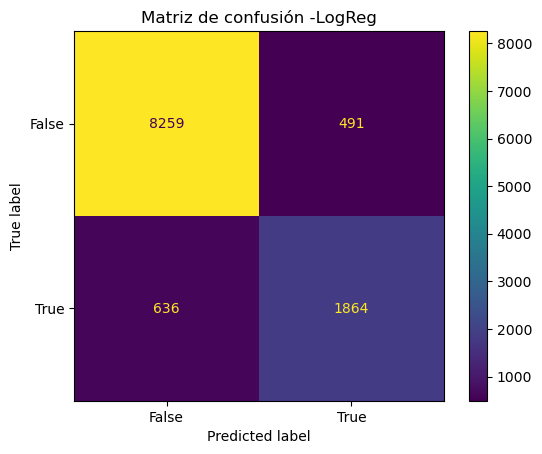

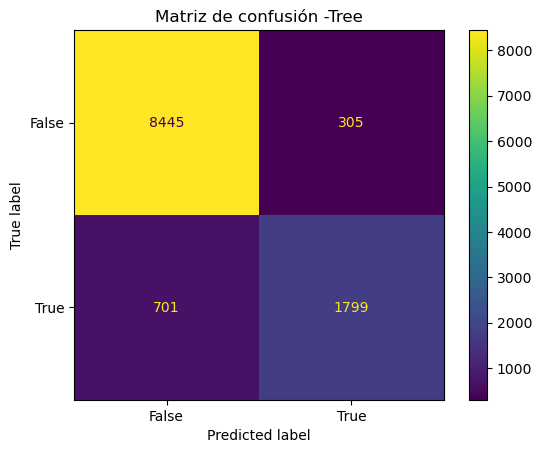

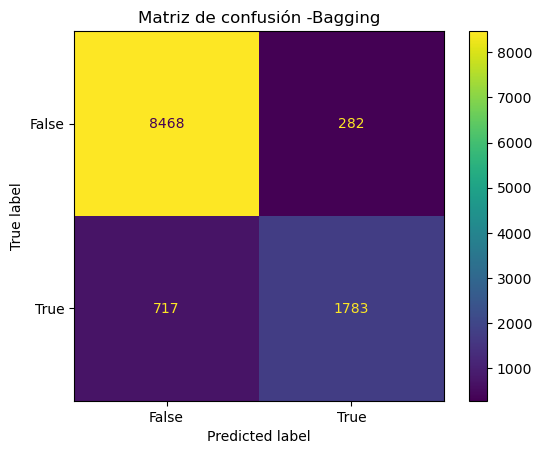

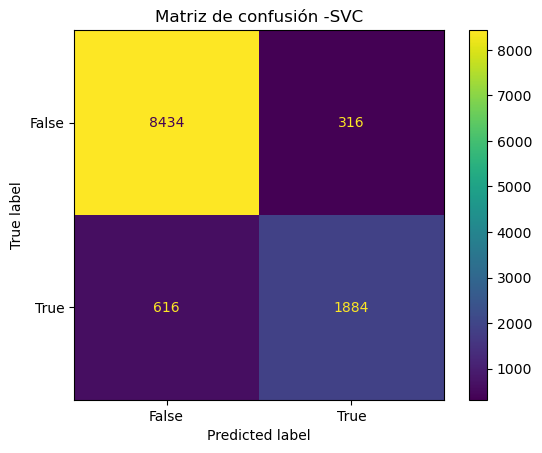

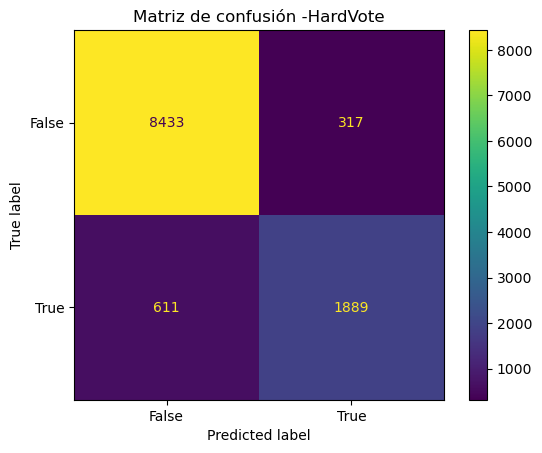

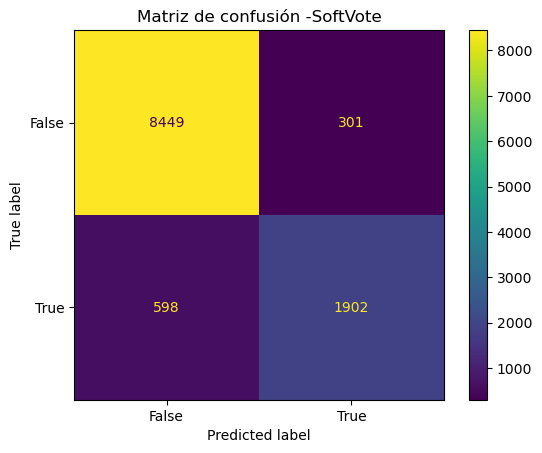

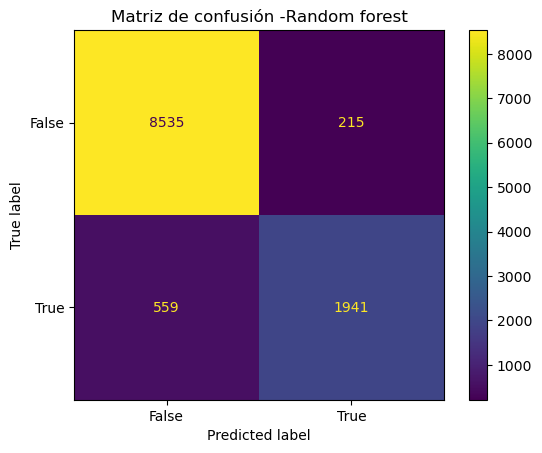

In [166]:
def cargar_matriz(matriz,clases,modelo_name):  
    fig, ax = plt.subplots() 
    disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=clases.classes_)
    disp.plot(ax=ax)          
    ax.set_title("Matriz de confusión -" + modelo_name) 
    plt.show()              


nombres_y_matrices = list(map(lambda d: cargar_matriz(d['matriz'], d['modelo'],d['nombre']), matrices))

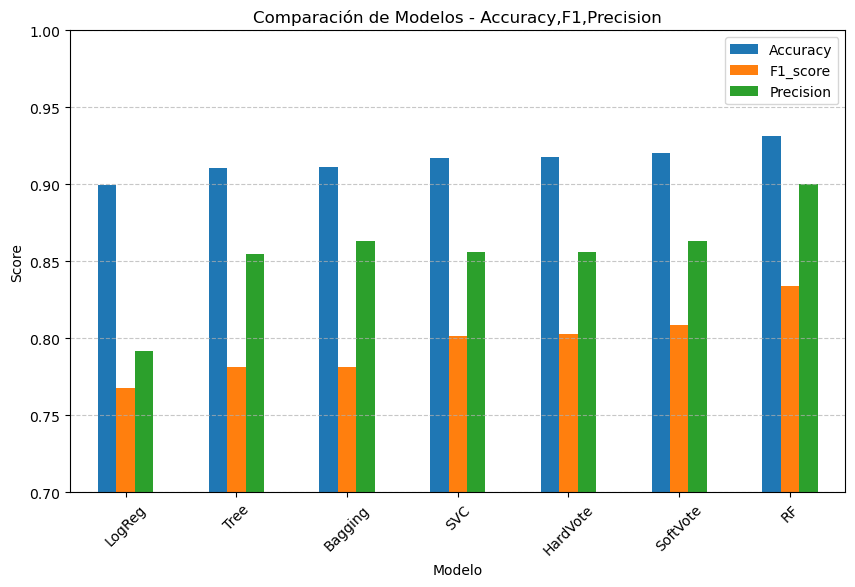

In [169]:
df_metricas = pd.DataFrame(metricas)

ax = df_metricas.plot(x="Modelo", y=["Accuracy", "F1_score","Precision"], kind="bar", figsize=(10,6))
plt.title("Comparación de Modelos - Accuracy,F1,Precision")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.ylim(0.7, 1.0)
plt.legend(["Accuracy", "F1_score","Precision"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

30
30


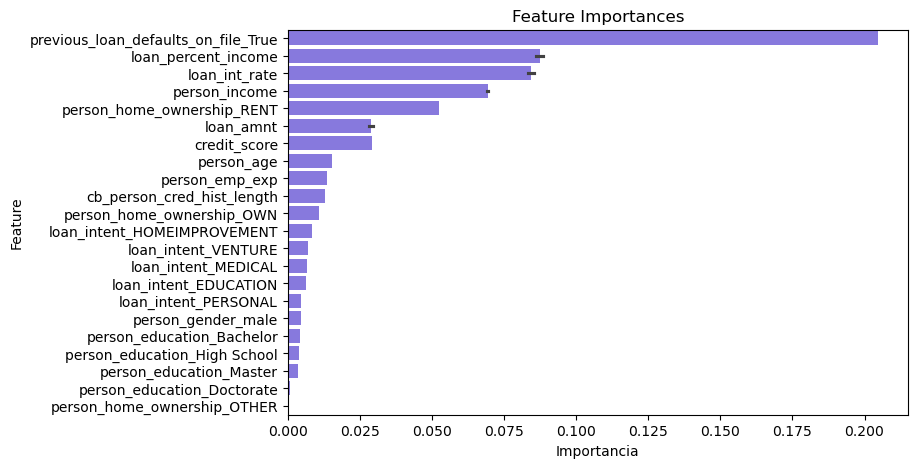

In [168]:

name_features =X.columns
mdi = rf.feature_importances_
df_importancia = pd.DataFrame({'Feature':name_features,'Importancia':mdi})

df_importancia.head()
df_importancia = df_importancia.sort_values(by='Importancia', ascending=False)


plt.figure(figsize=(8,5))
sns.barplot(x='Importancia', y='Feature', data=df_importancia, color='mediumslateblue')
plt.title('Feature Importances')
plt.xlabel('Importancia')
plt.ylabel('Feature')
plt.show()

**Discusión** (10–15 líneas): ¿qué método funcionó mejor y por qué? Relaciona con diversidad, varianza, *oob*, y la posible calibración de probabilidades (hard vs soft voting).

Una vez presentado los gráficos y obtenidos los datos, podemos observar que el método que mejor desempeño tuvo fue Random Forest, este modelo intenta reducir el sesgo para hacer el modelo más general, introduciendo varianza, además, el hecho de que este modelo utilice N árboles permite utilizar técnicas estadísticas como Bootstrap que permiten estimar parámetros acerca de la población (en este caso, acerca de nuevos datos). El OOB Score fue de 0.930 aproximadamente, lo cual nos dice que el modelo nos proporcionó una alta generalización, lo cual concuerda con lo anteriormente mencionado.
